BI_LSTM

In [ ]:
from google.colab import drive
# mounting google drive
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

Load Train and Test data

In [ ]:
train_dt = pd.read_csv('train.csv')
test_dt = pd.read_csv('test.csv')

In [ ]:
train_dt.columns

Index(['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'], dtype='object')

Define TPU usage

In [ ]:
import tensorflow as tf
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    tpu_strategy = tf.distribute.TPUStrategy(TPU)
except ValueError:
    tpu_strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', tpu_strategy.num_replicas_in_sync)

Number of replicas: 8


In [ ]:
#train_dt = train_dt.loc[train_dt['language'] =='English']

Combining both premise and hypothesis data

In [ ]:
train_dt.premise.astype(str).str.cat(train_dt.hypothesis).head()

0    and these comments were considered in formulat...
1    These are issues that we wrestle with in pract...
2    Des petites choses comme celles-là font une di...
3    you know they can't really defend themselves l...
4    ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...
Name: premise, dtype: object

In [ ]:
train_inp = train_dt.premise.astype(str).str.cat(train_dt.hypothesis)
train_out = train_dt['label']

In [ ]:
train_inp.shape, train_out.shape

((12120,), (12120,))

Plot the bar chart based on given classification

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


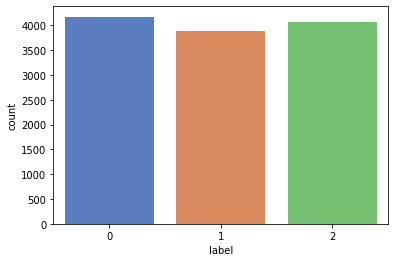

Number of entailment:  4176
Number of neutral:  4064
Number of contradiction:  3880


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

y = train_dt['label']
ax = sns.countplot(y, label="Count", palette="muted")
entailment, neutral, contradiction = y.value_counts()
plt.show()
print('Number of entailment: ', entailment)
print('Number of neutral: ', neutral)
print('Number of contradiction: ', contradiction)

Creating the pad sequence for the given data

In [ ]:
from keras.utils import pad_sequences

max_words = 1000
max_len = 500
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(train_inp)
sequences = tok.texts_to_sequences(train_inp)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

Define the Model

In [ ]:
from tensorflow.keras.layers import Bidirectional, Reshape, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate

In [ ]:
def RNN_BILSTM():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,250,input_length=max_len)(inputs)
    layer = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(layer)
    layer = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(layer)
    layer = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(layer)
    avg_pool = GlobalAveragePooling1D()(layer)
    max_pool = GlobalMaxPooling1D()(layer)
    layer = concatenate([avg_pool, max_pool])
    layer = Dense(3, activation="softmax", name="final_output")(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model



Create the model and compile

In [ ]:
with tpu_strategy.scope():
  bilstm_model = RNN_BILSTM()

In [ ]:
bilstm_model.summary()
bilstm_model.compile(loss='sparse_categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 500)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 500, 250)     250000      ['inputs[0][0]']                 
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 500, 256)    388096      ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 bidirectional_7 (Bidirectional  (None, 500, 256)    394240      ['bidirectional_6[0][0]']  

In [ ]:
bilstm_history = bilstm_model.fit(sequences_matrix,train_out,batch_size=16*tpu_strategy.num_replicas_in_sync,epochs=6,
          validation_split=0.2, verbose=1)

Epoch 1/6
76/76 [==============================] - 58s 764ms/step - loss: 1.0188 - accuracy: 0.4632 - val_loss: 1.0859 - val_accuracy: 0.3952
Epoch 2/6
76/76 [==============================] - 58s 764ms/step - loss: 0.9865 - accuracy: 0.4889 - val_loss: 1.1124 - val_accuracy: 0.3886
Epoch 3/6
76/76 [==============================] - 58s 764ms/step - loss: 0.9529 - accuracy: 0.5131 - val_loss: 1.1854 - val_accuracy: 0.4047
Epoch 4/6
76/76 [==============================] - 58s 764ms/step - loss: 0.9220 - accuracy: 0.5290 - val_loss: 1.2262 - val_accuracy: 0.3841
Epoch 5/6
76/76 [==============================] - 58s 764ms/step - loss: 0.8918 - accuracy: 0.5487 - val_loss: 1.2583 - val_accuracy: 0.3812
Epoch 6/6
76/76 [==============================] - 58s 764ms/step - loss: 0.8601 - accuracy: 0.5747 - val_loss: 1.3967 - val_accuracy: 0.3940


Plot the accuracy

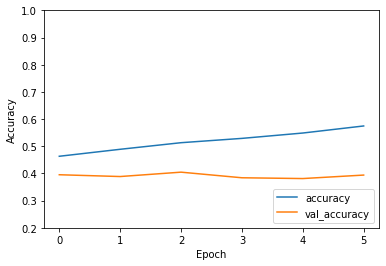

In [ ]:
plt.plot(bilstm_history.history['accuracy'], label='accuracy')
plt.plot(bilstm_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')
plt.show()

Prediction

In [ ]:
test_inp = test_dt.premise.astype(str).str.cat(test_dt.hypothesis)

In [ ]:
test_sequences = tok.texts_to_sequences(test_inp)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
test_pred=[np.argmax(i) for i in bilstm_model.predict(test_sequences_matrix)]

163/163 [==============================] - 16s 88ms/step


In [ ]:
pd.DataFrame(test_pred).value_counts()

0    2016
2    1606
1    1573
dtype: int64

In [ ]:
pd.DataFrame({'id':test_dt.id,
'prediction':test_pred}).to_csv('submission.csv',index=False)